# Script for Fig. 2G NVS et al. (2021)

In [ ]:
import json
import numpy as np
from copy import deepcopy
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import os
from matplotlib import cm
import sys
sys.path.insert(0, '/Users/natvan/CortexControl.app/Contents/MacOS/teili/')

from teili.tools.visualizer.DataViewers import PlotSettings
from teili.tools.visualizer.DataModels import EventsModel, StateVariablesModel
from teili.tools.visualizer.DataControllers import DataController, LineplotController, RasterplotController
from utils_natacha_3 import get_meanfiringrate_from_network_activity,get_network_activity_as_matrix, SpikeEvents, load_recordings_into_spikeevents

DC = DataController()

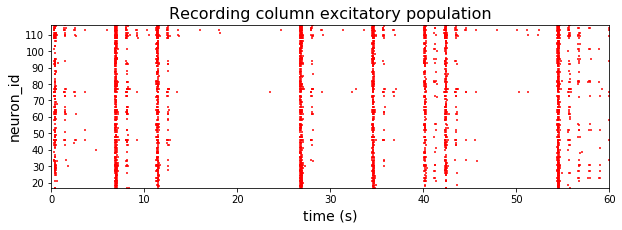

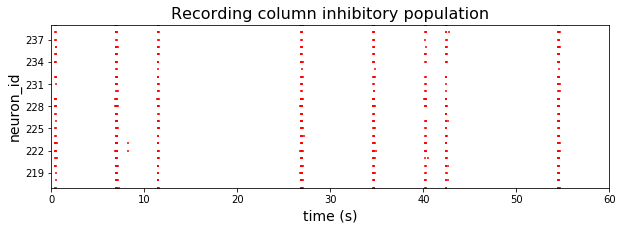

In [3]:
path_to_recording = '/Users/natvan/CortexControl_Study/rec/TEST/newb/code_updated//111347_OD1_CODE_UPDATED.json'

neuron_ids_col3 = list(range(17, 116+1))
neuron_ids_col3.remove(61)
neuron_ids_col3.remove(107)
neuron_ids_col3.remove(90)
neuron_ids_col3.remove(74)
neuron_ids_col3.remove(65)
neuron_ids_col3.remove(47)
neuron_ids_col3.remove(57)
neuron_ids_inh = list(range(217, 240))
all_neuron_ids = neuron_ids_col3 + neuron_ids_inh

min_neuron_id = np.min(all_neuron_ids)
max_neuron_id = np.max(all_neuron_ids)

network_activity_org = {}
all_active_neuron_ids = {}

rec_name_exc = 'Recording Column'
#path_to_recording= '/Users/natvan/CortexControl_Study/rec/TEST/newb/code_updated//111347_OD1_CODE_UPDATED.json'

all_active_neuron_ids[rec_name_exc] = neuron_ids_col3
network_activity_org = {rec_name_exc: load_recordings_into_spikeevents(path_to_recording=path_to_recording, active_neuron_ids=all_active_neuron_ids[rec_name_exc])}

rec_name_inh = 'Recording ColumnI'
network_activity_org[rec_name_inh] = load_recordings_into_spikeevents(path_to_recording=path_to_recording, active_neuron_ids=neuron_ids_inh) #, column_core=core_nr_inh, column_chip=chip_nr_inh,reset_start_time=True, reset_neuron_ids=False)
all_active_neuron_ids[rec_name_inh] = neuron_ids_inh

# create rasterplot

fig, (ax) = plt.subplots(ncols=1, figsize=(10, 3))
rec_name_to_show = 'Recording Column' #f1 dev in OD
neuron_id_min = np.min(all_active_neuron_ids[rec_name_to_show])
neuron_id_max = np.max(all_active_neuron_ids[rec_name_to_show])
eventsmodel  = EventsModel(neuron_ids=network_activity_org[rec_name_to_show].neuron_id, spike_times=network_activity_org[rec_name_to_show].ts)
RasterplotController([eventsmodel], xlabel='time (s)', ylabel='neuron_id', neuron_id_range=(neuron_id_min, neuron_id_max), 
                     title = 'Recording column excitatory population', time_range=(0, 60), mainfig=fig, subfig_rasterplot=ax, show_immediately=False)

# create rasterplot

fig, (ax) = plt.subplots(ncols=1, figsize=(10, 3))
rec_name_to_show = 'Recording ColumnI' #f1 dev in OD
neuron_id_min = np.min(all_active_neuron_ids[rec_name_to_show])
neuron_id_max = np.max(all_active_neuron_ids[rec_name_to_show])
eventsmodel  = EventsModel(neuron_ids=network_activity_org[rec_name_to_show].neuron_id, spike_times=network_activity_org[rec_name_to_show].ts)
RasterplotController([eventsmodel], xlabel='time (s)', ylabel='neuron_id', neuron_id_range=(neuron_id_min, neuron_id_max), 
                     title = 'Recording column inhibitory population', time_range=(0, 60), mainfig=fig, subfig_rasterplot=ax, show_immediately=False)





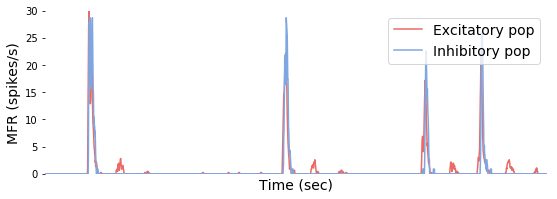

In [4]:
# to keep original throughout filtering actions
network_activity = deepcopy(network_activity_org)

myplotsettings = PlotSettings(colors=[(0.917, 0.419, 0.4),(0.494, 0.650, 0.878)])


# filter for time interval & normalize neuron_ids
t_start = 25  # [s]
t_end   = 45. # [s]
for net_activity_org, net_activity in zip([network_activity_org], [network_activity]):
    for column_name, column_events in net_activity_org.items():
        net_activity[column_name].ts, net_activity[column_name].neuron_id = DC.filter_events(all_spike_times=column_events.ts, all_neuron_ids=column_events.neuron_id, interval=(t_start, t_end))

# get mean firing rate
t_start = 25
t_end = 45
step_size = 0.01
window_size = 0.05

get_meanfiringrate_from_network_activity(network_activity=network_activity_org,
                                         max_neuron_id=max_neuron_id, t_start=t_start, t_end=t_end,
                                         step_size=step_size, window_size=window_size,
                                         pop_firing_rate=False,  active_neuron_ids=all_active_neuron_ids, 
                                         pop_average=True)

# plot mfr over time with/without adaptation
#myplotsettings = PlotSettings(colors=['red', 'lightskyblue',])
#myplotsettings = PlotSettings(colors=np.asarray([(1,0,0, 1),
#                             (0,0,1,0.6), 
#                             (0,0,0, 0)]))

fig, ax = plt.subplots(nrows = 1, figsize=(9,3))
column_events_inh = network_activity_org[rec_name_inh]
column_events_exc = network_activity_org[rec_name_exc]
data = [(column_events_exc, ('t_mfr', 'mfr')), (column_events_inh, ('t_mfr', 'mfr'))]
LineplotController(DataModel_to_x_and_y_attr=data , subgroup_labels=['Excitatory pop', 'Inhibitory pop'],  
                   y_range = [0,30], x_range=(t_start, t_end), title = None,
                   xlabel='Time (sec)', ylabel='MFR (spikes/s)', mainfig=fig, subfig=ax, 
                   show_immediately=False,  MyPlotSettings= myplotsettings) 
ax.set_xticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

#plt.savefig('FIG8A.pdf')